In [1]:
!apt install git
!git clone https://github.com/ylucena40/POC

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.25.1-1ubuntu3.11).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
Cloning into 'POC'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 10 (delta 4), reused 10 (delta 4), pack-reused 0
Unpacking objects: 100% (10/10), 17.94 KiB | 1.99 MiB/s, done.


In [2]:
 !mkdir img

In [3]:
!pip install emcee

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 2.7 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emcee
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings

Função para Calcular RMSE e MAE

In [5]:
def evaluate_performance(y_true, y_pred,vetor_rmse,vetor_mae):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    vetor_rmse.append(rmse)
    vetor_mae.append(mae)

Definir as variáveis do modelo


In [6]:
def log_prob_1v(x, y):
    intercepto, slope, log_s = x
    sigma = np.exp(log_s)
    modelo = intercepto + slope * y[:-1]
    log_likelihood = -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (y[1:] - modelo) ** 2 / sigma ** 2)
    log_prior = -0.5 * np.sum((x - [0, 0, 0]) ** 2 / [1, 1, 1])
    return log_prior + log_likelihood

In [7]:
def log_prob_4v(x, y):
    intercepto, slope_casosNovos, slope_casosAcumulado, slope_obitosNovos, slope_obitosAcumulado, log_s = x
    sigma = np.exp(log_s)
    modelo = intercepto + slope_casosNovos * y['casosNovos'][:-1] + slope_casosAcumulado * y['casosAcumulado'][:-1] + slope_obitosNovos * y['obitosNovos'][:-1] + slope_obitosAcumulado * y['obitosAcumulado'][:-1]
    log_likelihood = -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (y['casosNovos'][1:] - modelo) ** 2 / sigma ** 2)
    log_prior = -0.5 * np.sum((x - [0, 0, 0, 0, 0, 0]) ** 2 / [1, 1, 1, 1, 1, 1])
    return log_prior + log_likelihood

Função MCMC para 1 variável de interesse (CasosNovos)

In [8]:
def mcmc_1v(dados):
  # Estimar a distribuição posterior do modelo
    nwalkers, ndim = 50, 3
    pos = np.random.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_1v, args=[dados])
    sampler.run_mcmc(pos, 1000)

    # Obter amostras das variáveis do modelo
    intercepto_samples = sampler.chain[:, :, 0].ravel()
    slope_samples = sampler.chain[:, :, 1].ravel()
    log_s_samples = sampler.chain[:, :, 2].ravel()

    # Obter amostras do modelo predito
    idx = np.arange(len(dados))
    intercepto_predito = np.median(intercepto_samples) + np.median(slope_samples) * dados[idx]
    slope_predito = np.median(slope_samples)
    sigma_predito = np.exp(np.median(log_s_samples))
    y_predito = np.random.normal(intercepto_predito, sigma_predito)

    return y_predito

Função MCMC para 4 variáveis de interesse (CasosNovos, CasosAcumulado, ÓbitosNovos, ÓbitosAcumulados)

In [9]:
def mcmc_4v(dados):
  # Estimar a distribuição posterior do modelo
    nwalkers, ndim = 50, 6
    pos = np.random.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_4v, args=[dados])
    sampler.run_mcmc(pos, 1000)

    # Obter amostras das variáveis do modelo
    intercepto_samples = sampler.chain[:, :, 0].ravel()
    slope_casosNovos_samples = sampler.chain[:, :, 1].ravel()
    slope_casosAcumulado_samples = sampler.chain[:, :, 2].ravel()
    slope_obitosNovos_samples = sampler.chain[:, :, 3].ravel()
    slope_obitosAcumulado_samples = sampler.chain[:, :, 4].ravel()
    log_s_samples = sampler.chain[:, :, 5].ravel()

    # Obter amostras do modelo predito
    idx = np.arange(len(dados))
    intercepto_predito = np.median(intercepto_samples) + np.median(slope_casosNovos_samples) * dados['casosNovos'].iloc[idx] + np.median(slope_casosAcumulado_samples) * dados['casosAcumulado'].iloc[idx] + np.median(slope_obitosNovos_samples) * dados['obitosNovos'].iloc[idx] + np.median(slope_obitosAcumulado_samples) * dados['obitosAcumulado'].iloc[idx]
    slope_casosNovos_predito = np.median(slope_casosNovos_samples)
    slope_casosAcumulado_predito = np.median(slope_casosAcumulado_samples)
    slope_obitosNovos_predito = np.median(slope_obitosNovos_samples)
    slope_obitosAcumulado_predito = np.median(slope_obitosAcumulado_samples)
    sigma_predito = np.exp(np.median(log_s_samples))
    y_predito = np.random.normal(intercepto_predito, sigma_predito)

    return y_predito

Abertura data base

In [10]:
dados = pd.read_csv('POC/dataset/tabela_final.csv')
#dados = pd.read_csv('POC/dataset/tabelaSV.csv')
#dados = pd.read_csv('POC/dataset/tabela.csv')
x_data = dados['data']

#dados 1 variável de interesse
dados_1v = dados
dados_1v = dados_1v.drop(columns=['casosAcumulado','obitosNovos','obitosAcumulado'])
dados_1v['data'] = pd.to_datetime(dados_1v['data'])

dados_1v = dados_1v.set_index('data')
dados_1v = dados_1v['casosNovos']

#dados 4 variáveis de interesse
dados_4v = dados
dados_4v['data'] = pd.to_datetime(dados_4v['data'])

dados_4v = dados_4v.set_index('data')

Chamada dos algoritmos

In [11]:
# Desabilitar a saída
warnings.filterwarnings("ignore", category=RuntimeWarning)

y_predito_1v = mcmc_1v(dados_1v)
y_predito_4v = mcmc_4v(dados_4v)

Plot

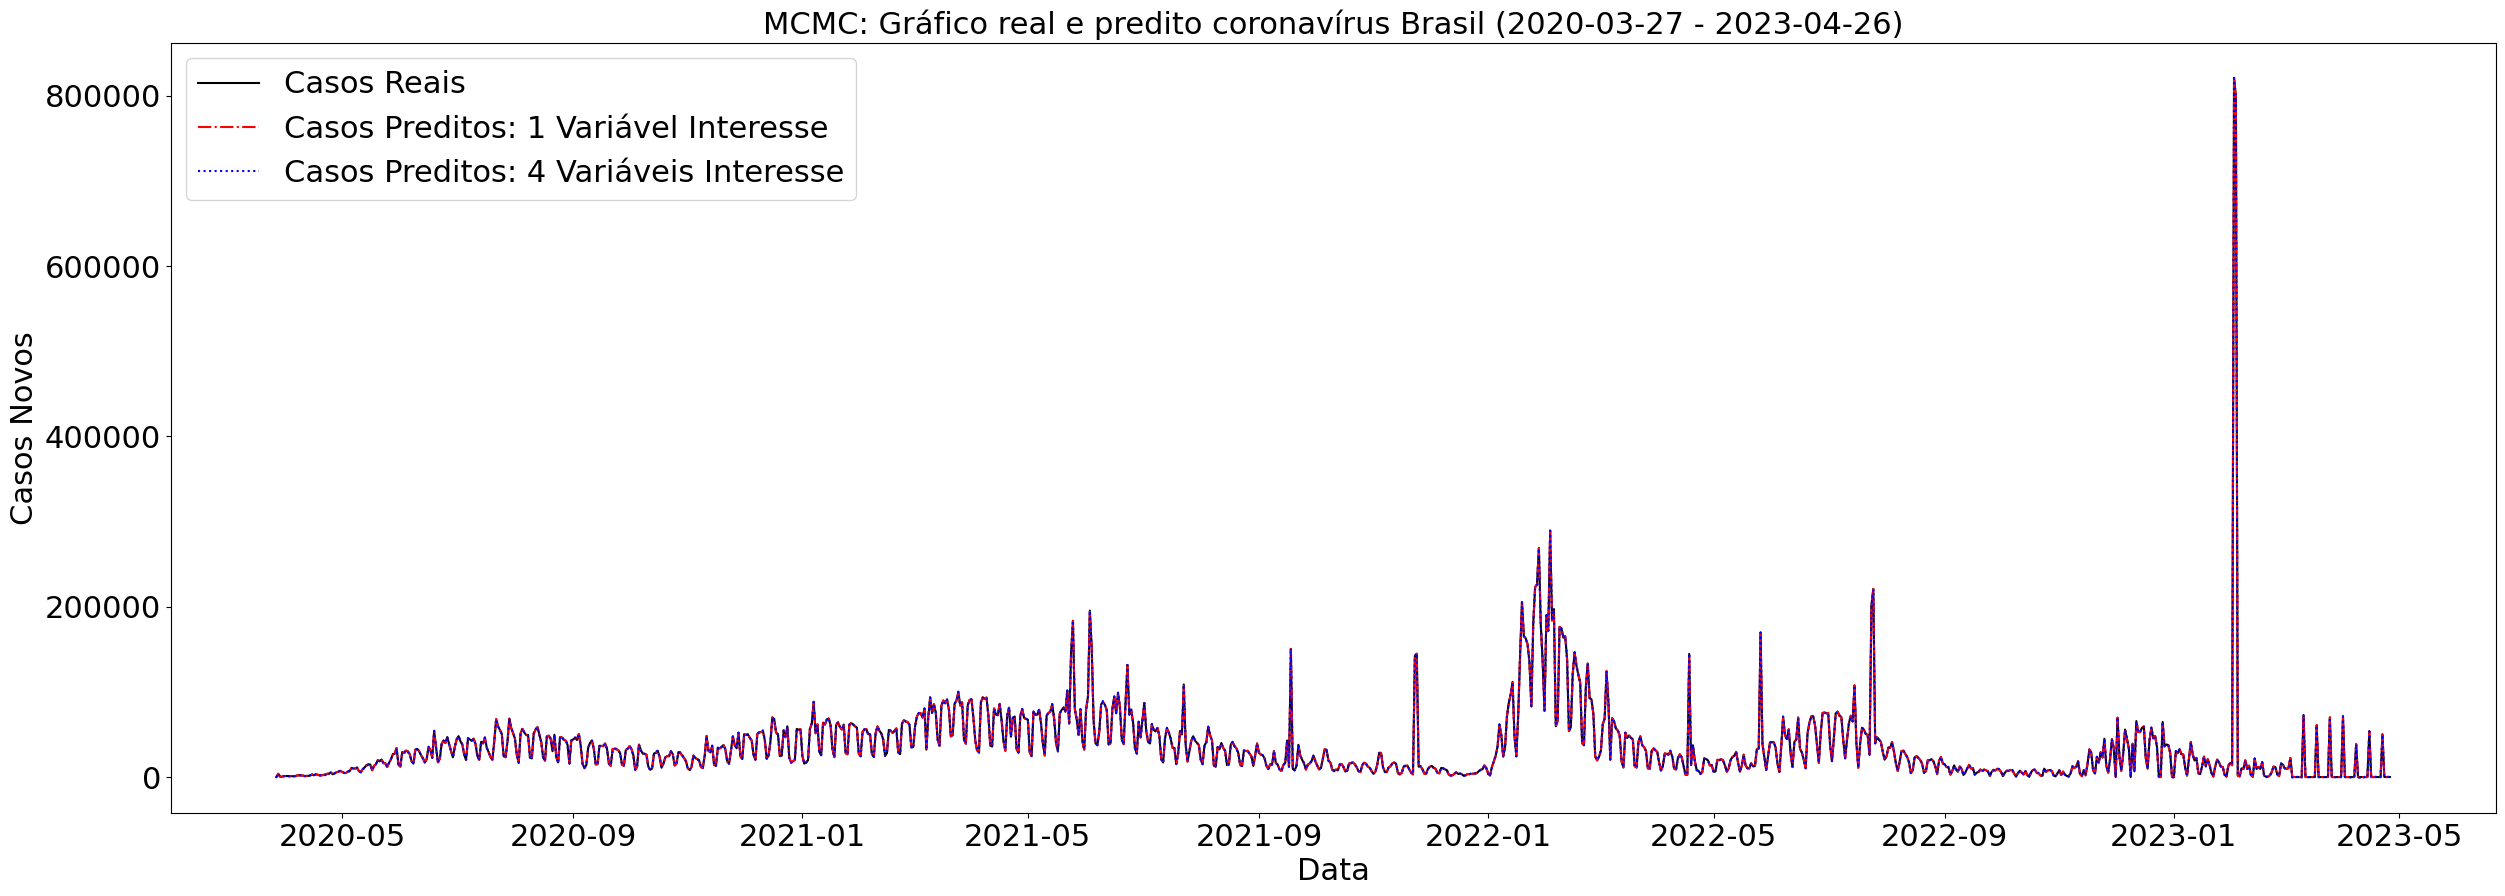

In [12]:
data1 = str(x_data[0]).split(' ')
data2 = str(x_data[len(x_data)-1]).split(' ')

plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22

# Plotar dados originais e preditos
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(dados_1v.index, dados['casosNovos'], color='black', label='Casos Reais')
ax.plot(dados_1v.index, y_predito_1v, color='red', label='Casos Preditos: 1 Variável Interesse', ls='-.')
ax.plot(dados_1v.index, y_predito_4v, color='blue', label='Casos Preditos: 4 Variáveis Interesse', ls='dotted')
ax.set_title('MCMC: Gráfico real e predito coronavírus Brasil ('+ str(data1[0]) + ' - ' + str(data2[0]) + ')',fontsize=22)
ax.set_xlabel('Data',fontsize=22)
ax.set_ylabel('Casos Novos',fontsize=22)
ax.legend(prop={"size":22})

plt.savefig("img/grafico_comp.png")
plt.show()

plt.close('all')

RMSE - MAE

In [13]:
vetor_rmse_1v = []
vetor_rmse_4v = []
vetor_mae_1v  = []
vetor_mae_4v  = []
evaluate_performance(dados['casosNovos'], y_predito_1v,vetor_rmse_1v,vetor_mae_1v)
evaluate_performance(dados['casosNovos'], y_predito_4v,vetor_rmse_4v,vetor_mae_4v)

In [14]:
formatted_number = f"{vetor_rmse_1v[0]:.10f}"
print(formatted_number)
formatted_number = f"{vetor_mae_1v[0]:.10f}"
print(formatted_number)
print("rmse_1")
print(vetor_rmse_1v)
print("mae_1")
print(vetor_mae_1v)
print("rmse_4")
print(vetor_rmse_4v)
print("mae_4")
print(vetor_mae_4v)

0.0001435257
0.0001145890
rmse_1
[0.00014352569984833077]
mae_1
[0.00011458904238172442]
rmse_4
[414.53756689179664]
mae_4
[328.22900171676963]
